# Financial data analytics

In this section you will be challenged with a couple of analytical questions about the data. There might be no single correct answer to some of the questions, feel free to provide solutions which make the most sense to you. We know that you might not have the time to provide solutions to all the questions: try to finalize at least 3 of them and focus on the quality of your answers.

The objective is to implement the solutions using Python and we would be most happy if you adopt PySpark for at least some of the exercises. However, you can pick the programming language of your choice.

<img src = "img/EntityRelation.png"></src>

In [1322]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when, lit
from pyspark.sql.functions import col, udf

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from datetime import datetime

import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import os

In [1323]:
ss = SparkSession.builder.appName("Scigility Test Challenge").getOrCreate()

## Preprocessing

<font color="green">In this part I work on loading the data, casting them in the correct format and removing unusable ones.</font>

In [1324]:
df_trans = ss.read.csv("data/trans.csv",sep=';', inferSchema=False, header=True)

In [1325]:
@udf
def convertDate(x):
    try:
        cv_date = datetime.strptime(x, '%Y-%m-%d')
    except:
        cv_date = "error"
    return cv_date

In [1326]:
df_trans_cast = df_trans.withColumn("date_2", convertDate("date"))

In [1327]:
df_trans_cast.filter(col("date_2")=="error").count()

3141

<font color="green">I choose to remove wrong data format (we can easily find again the wrong records).

For the dates records, I will work with String only for a better display.</font>

In [1328]:
df_trans_clean = df_trans_cast.filter(col("date_2")!="error")

In [1329]:
df_trans_cast = df_trans_clean \
    .withColumn("trans_id", df_trans_clean["trans_id"].cast("int")) \
    .withColumn("account_id", df_trans_clean["account_id"].cast("int")) \
    .withColumn("amount", df_trans_clean["amount"].cast("int")) \
    .withColumn("balance", df_trans_clean["balance"].cast("int")) \
    .withColumn("account", df_trans_clean["account"].cast("int")) \
    .drop("date_2")

In [1330]:
df_trans_cast.show(5)

+--------+----------+----------+------+---------+------+-------+--------+------+----+-------+
|trans_id|account_id|      date|  type|operation|amount|balance|k_symbol|branch|bank|account|
+--------+----------+----------+------+---------+------+-------+--------+------+----+-------+
|  967842|      1532|1998-05-31|PRIJEM|     null|   253|  62661|    UROK|    AR|null|      0|
|  271012|      1499|1998-01-09|PRIJEM|    VKLAD|  5500|  49790|    null|    AR|null|      0|
|  971490|      1645|1996-11-30|PRIJEM|     null|    43|  19460|    UROK|    AR|null|      0|
|  605699|      3366|1996-10-28| VYDAJ|    VYBER|  9300|  38433|    null|    AR|null|      0|
|  443107|      2471|1998-07-30| VYDAJ|    VYBER|  7800|  56237|    null|    AR|null|      0|
+--------+----------+----------+------+---------+------+-------+--------+------+----+-------+
only showing top 5 rows



In [1331]:
df_loan = ss.read.csv("data/loan.csv",sep=';', inferSchema=False, header=True)

In [1332]:
df_loan_cast = df_loan \
    .withColumn("loan_id", df_loan["loan_id"].cast("int")) \
    .withColumn("account_id", df_loan["account_id"].cast("int")) \
    .withColumn("amount", df_loan["amount"].cast("int")) \
    .withColumn("duration", df_loan["duration"].cast("int")) \
    .withColumn("payments", df_loan["payments"].cast("float"))

In [1333]:
df_loan_cast.show(5)

+-------+----------+----------+------+--------+--------+------+
|loan_id|account_id|      date|amount|duration|payments|status|
+-------+----------+----------+------+--------+--------+------+
|   4959|         2|1994-01-05| 80952|      24|  3373.0|     A|
|   4961|        19|1996-04-29| 30276|      12|  2523.0|     B|
|   4962|        25|1997-12-08| 30276|      12|  2523.0|     A|
|   4967|        37|1998-10-14|318480|      60|  5308.0|     D|
|   4968|        38|1998-04-19|110736|      48|  2307.0|     C|
+-------+----------+----------+------+--------+--------+------+
only showing top 5 rows



In [1334]:
df_order = ss.read.csv("data/order.csv", sep=';', inferSchema=False, header=True)

In [1335]:
df_order_cast = df_order \
    .withColumn("order_id", df_order["order_id"].cast("int")) \
    .withColumn("account_id", df_order["account_id"].cast("int")) \
    .withColumn("account_to", df_order["account_to"].cast("int")) \
    .withColumn("amount", df_order["amount"].cast("float"))

In [1336]:
df_order.show(5)

+--------+----------+-------+----------+------+--------+
|order_id|account_id|bank_to|account_to|amount|k_symbol|
+--------+----------+-------+----------+------+--------+
|   29401|         1|     YZ|  87144583|2452.0|    SIPO|
|   29402|         2|     ST|  89597016|3372.7|    UVER|
|   29403|         2|     QR|  13943797|7266.0|    SIPO|
|   29404|         3|     WX|  83084338|1135.0|    SIPO|
|   29405|         3|     CD|  24485939| 327.0|    null|
+--------+----------+-------+----------+------+--------+
only showing top 5 rows



In [1337]:
df_district = ss.read.csv("data/district.csv", sep=';', inferSchema=False, header=True)

In [1338]:
df_district_cast = df_district \
    .withColumn("district_id", df_district["district_id"].cast("int")) \
    .withColumn("A4", df_district["A4"].cast("int")) \
    .withColumn("A5", df_district["A5"].cast("int")) \
    .withColumn("A6", df_district["A6"].cast("int")) \
    .withColumn("A7", df_district["A7"].cast("int")) \
    .withColumn("A8", df_district["A8"].cast("int")) \
    .withColumn("A9", df_district["A9"].cast("int")) \
    .withColumn("A11", df_district["A11"].cast("int")) \
    .withColumn("A14", df_district["A14"].cast("int")) \
    .withColumn("A15", df_district["A15"].cast("int")) \
    .withColumn("A16", df_district["A16"].cast("int")) \
    .withColumn("A10", df_district["A10"].cast("float")) \
    .withColumn("A12", df_district["A12"].cast("float")) \
    .withColumn("A13", df_district["A13"].cast("float"))

In [1339]:
df_district_cast.show(5)

+-----------+-----------+---------------+-------+---+---+---+---+---+-----+-----+---+----+---+-----+-----+
|district_id|         A2|             A3|     A4| A5| A6| A7| A8| A9|  A10|  A11|A12| A13|A14|  A15|  A16|
+-----------+-----------+---------------+-------+---+---+---+---+---+-----+-----+---+----+---+-----+-----+
|          1|Hl.m. Praha|         Prague|1204953|  0|  0|  0|  1|  1|100.0|12541|0.2|0.43|167|85677|99107|
|          2|    Benesov|central Bohemia|  88884| 80| 26|  6|  2|  5| 46.7| 8507|1.6|1.85|132| 2159| 2674|
|          3|     Beroun|central Bohemia|  75232| 55| 26|  4|  1|  5| 41.7| 8980|1.9|2.21|111| 2824| 2813|
|          4|     Kladno|central Bohemia| 149893| 63| 29|  6|  2|  6| 67.4| 9753|4.6|5.05|109| 5244| 5892|
|          5|      Kolin|central Bohemia|  95616| 65| 30|  4|  1|  6| 51.4| 9307|3.8|4.43|118| 2616| 3040|
+-----------+-----------+---------------+-------+---+---+---+---+---+-----+-----+---+----+---+-----+-----+
only showing top 5 rows



In [1340]:
df_account = ss.read.csv("data/account.csv", sep=';', inferSchema=False, header=True)

In [1341]:
df_account_cast = df_account \
    .withColumn("account_id", df_account["account_id"].cast("int")) \
    .withColumn("district_id", df_account["district_id"].cast("int"))

In [1342]:
df_account_cast.show(5)

+----------+-----------+----------------+----------+
|account_id|district_id|       frequency|      date|
+----------+-----------+----------------+----------+
|         1|         18|POPLATEK MESICNE|1995-03-24|
|         2|          1|POPLATEK MESICNE|1993-02-26|
|         3|          5|POPLATEK MESICNE|1997-07-07|
|         4|         12|POPLATEK MESICNE|1996-02-21|
|         5|         15|POPLATEK MESICNE|1997-05-30|
+----------+-----------+----------------+----------+
only showing top 5 rows



In [1343]:
df_disp = ss.read.csv("data/disp.csv", sep=";", inferSchema=False, header=True)

In [1344]:
df_disp_cast = df_disp \
    .withColumn("disp_id", df_disp["disp_id"].cast("int")) \
    .withColumn("account_id", df_disp["account_id"].cast("int")) \
    .withColumn("client_id", df_disp["client_id"].cast("int"))

In [1345]:
df_disp_cast.show(5)

+-------+---------+----------+---------+
|disp_id|client_id|account_id|     type|
+-------+---------+----------+---------+
|      1|        1|         1|    OWNER|
|      2|        2|         2|    OWNER|
|      3|        3|         2|DISPONENT|
|      4|        4|         3|    OWNER|
|      5|        5|         3|DISPONENT|
+-------+---------+----------+---------+
only showing top 5 rows



In [1346]:
df_client = ss.read.csv("data/client.csv", sep=";", inferSchema=False, header=True)

In [1347]:
df_client_cast = df_client \
    .withColumn("client_id", df_client["client_id"].cast("int")) \
    .withColumn("district_id", df_client["district_id"].cast("int"))

In [1348]:
df_client_cast.show(5)

+---------+------+----------+-----------+
|client_id|gender|birth_date|district_id|
+---------+------+----------+-----------+
|        1|     F|1970-12-13|         18|
|        2|     M|1945-02-04|          1|
|        3|     F|1940-10-09|          1|
|        4|     M|1956-12-01|          5|
|        5|     F|1960-07-03|          5|
+---------+------+----------+-----------+
only showing top 5 rows



In [1349]:
df_card = ss.read.csv("data/card.csv", sep=";", inferSchema=False, header=True)

In [1350]:
df_card_cast = df_card \
    .withColumn("card_id", df_card["card_id"].cast("int")) \
    .withColumn("disp_id", df_card["disp_id"].cast("int"))

In [1351]:
df_card_cast.show(5)

+-------+-------+-------+----------+
|card_id|disp_id|   type|    issued|
+-------+-------+-------+----------+
|      1|      9|   gold|1998-10-16|
|      2|     19|classic|1998-03-13|
|      3|     41|   gold|1995-09-03|
|      4|     42|classic|1998-11-26|
|      5|     51| junior|1995-04-24|
+-------+-------+-------+----------+
only showing top 5 rows



## Analytics

#### 1.

Look at some basic statistics of the data (mean, variance, etc.) of the “trans” table to understand it better. Create plots or visualizations of your choice (feel free to use the library you prefer. Hint: in case of Python, Matplotlib is probably best suited - in case of Scala you might want to use the Vegas library). Print and explain an aspect of your choice (that you think is interesting) in the notebook.

####  Amount basic statistics

In [1352]:
df_trans_cast.describe(["amount"]).show()

+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|          1053269|
|   mean|5929.523604131518|
| stddev|9524.746862150716|
|    min|                0|
|    max|            87400|
+-------+-----------------+



<font color="green">On average, transactions have an amount of 6K.</font>

#### Total number of transactions over time

In [1353]:
df_transaction_date = df_trans_cast \
    .groupBy('date') \
    .agg({'trans_id': 'count'}) \
    .select("date",col("count(trans_id)").alias("count")) \
    .orderBy(df_trans_cast.date.asc())

In [1354]:
df_transaction_date_pd = df_transaction_date.toPandas()

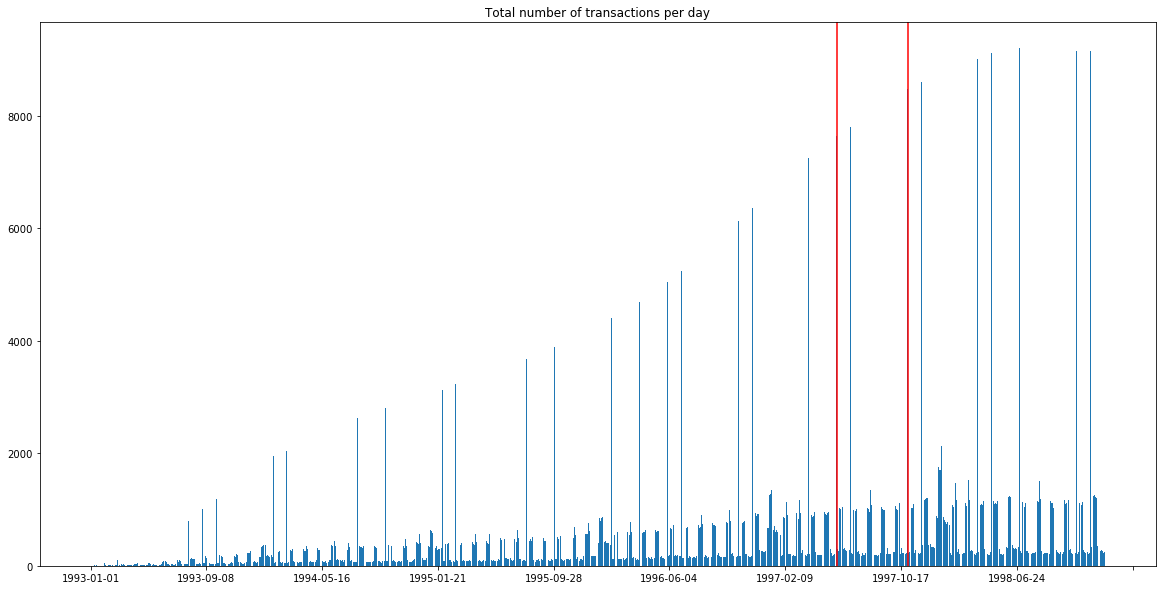

In [1355]:
plt.figure(figsize=(20, 10))
ax = plt.subplot()
myLocator = mticker.MaxNLocator(10)
ax.xaxis.set_major_locator(myLocator)
plt.bar(df_transaction_date_pd['date'],df_transaction_date_pd['count'])
plt.title("Total number of transactions per day")
plt.axvline("1997-06-01", c='red')
plt.axvline("1997-11-01", c='red')

<font color="green">We note:

- Number of transactions per day is increasing over time

- There seems to have a significant number of transactions happening twice a year</font>

#### Total amount of transactions over time

In [1356]:
df_amount_date = df_trans_cast \
    .groupBy('date') \
    .agg({'amount': 'sum'}) \
    .select("date",col("sum(amount)").alias("sum")) \
    .orderBy(df_trans_cast.date.asc())

In [1357]:
df_amount_date_pd = df_amount_date.toPandas()

Text(0.5, 1.0, 'Total amount of transactions on time (in millions)')

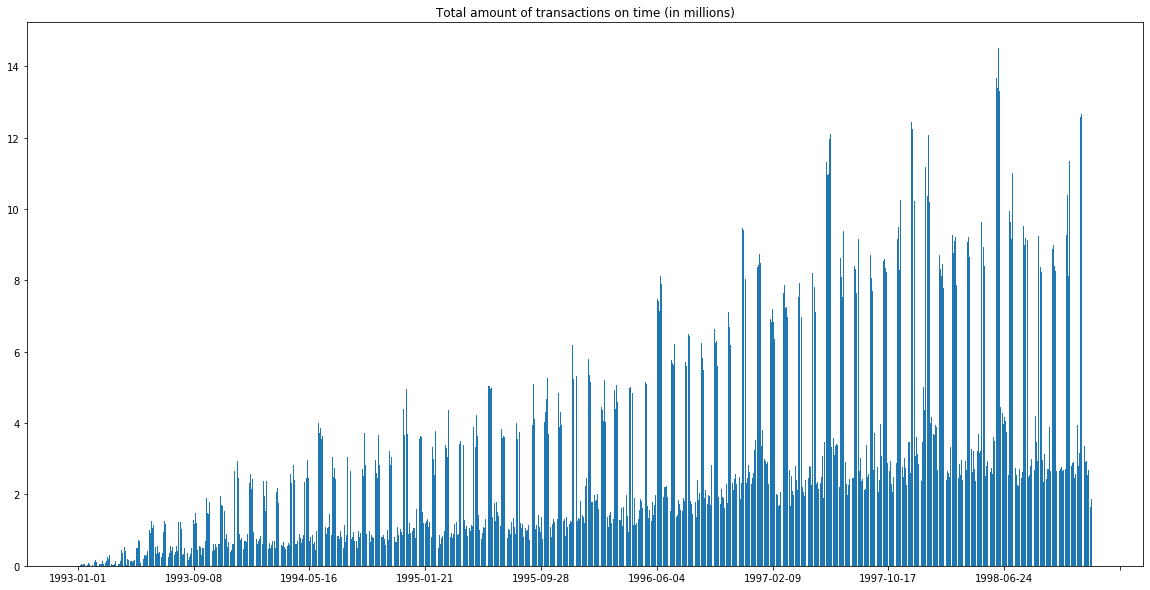

In [1358]:
plt.figure(figsize=(20, 10))
ax = plt.subplot()
ticks_y = mticker.FuncFormatter(lambda x, pos: int(x/1000000))
ax.yaxis.set_major_formatter(ticks_y)
myLocator = mticker.MaxNLocator(10)
ax.xaxis.set_major_locator(myLocator)
plt.bar(df_amount_date_pd['date'],df_amount_date_pd['sum'])
plt.title("Total amount of transactions on time (in millions)")

<font color="green">We note spikes happening regularly over time. We could thus think that the spikes are mostly caused by the number of transactions as seen previously.</font>

#### 4.

Visualize the average loan amount per district.

In [1359]:
df_loan_for_ave = df_loan_cast.select("account_id","amount")

In [1360]:
df_account_for_ave = df_account_cast.select("account_id","district_id")

In [1361]:
df_loan_district = df_loan_for_ave \
    .join(df_account_for_ave, df_loan_for_ave.account_id == df_account_for_ave.account_id, 'left') \
    .drop(df_loan_for_ave.account_id) \
    .drop(df_account_for_ave.account_id)

In [1362]:
df_loan_district_gp = df_loan_district \
    .groupBy('district_id') \
    .agg({'amount': 'avg'}) \
    .select("district_id",col("avg(amount)").alias("avg"))

In [1363]:
df_loan_district_gp.sort(col("avg").desc()).show(5)

+-----------+------------------+
|district_id|               avg|
+-----------+------------------+
|         46|          294730.0|
|         14|          251365.5|
|          3|          243466.0|
|         69|          242304.0|
|          6|232886.66666666666|
+-----------+------------------+
only showing top 5 rows



In [1364]:
df_loan_district_pd = df_loan_district_gp.toPandas()

Text(0.5, 1.0, 'Loan amount per district')

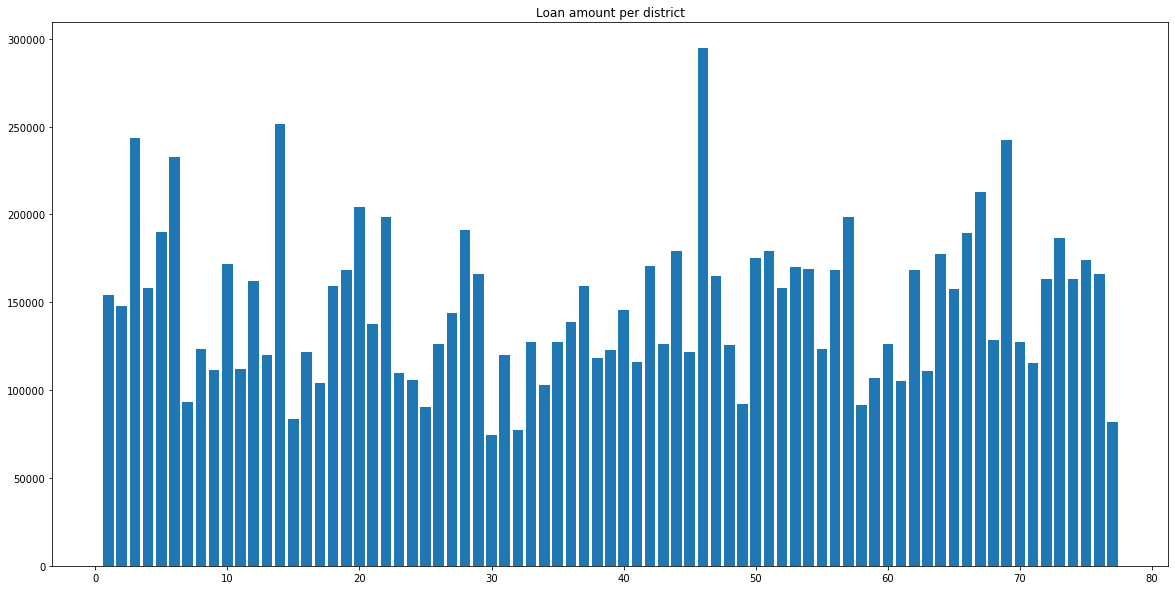

In [1365]:
plt.figure(figsize=(20,10))
plt.bar(df_loan_district_pd['district_id'],df_loan_district_pd["avg"])
plt.title("Loan amount per district")

In [1366]:
df_loan_district_gp.describe("avg").show(5)

+-------+------------------+
|summary|               avg|
+-------+------------------+
|  count|                77|
|   mean|148347.08592973108|
| stddev| 43582.93184090751|
|    min|           74262.0|
|    max|          294730.0|
+-------+------------------+



<font color="green">Loans are between 74K and 294K across all districts.

District 46 has the highest amount.</font>

## Credit risk prediction

#### 5.

Build an ML model that classifies if a certain loan will be paid or not. You can use any classification model you think is suitable (hint: if you’re using Spark, there are some available out of the box with MLlib - with Python and Scikit-Learn too). Note that the goal is not to get the accuracy as high as possible – it is completely OK to choose a simple model and not spend days on parameter tuning. Think about questions like:

- Which model do you choose and why?

- How do you do the training and how do you measure the model accuracy?

- Which are the variables contributing the most to the prediction?

- How accurate does your model get? If you think a higher accuracy is possible, what would be the next steps you take?


### Basic analysis

<font color="green">In this section I conducted simple analysis to understand better the data.</font>

#### Status

From data provider https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm :

'A' stands for contract finished, no problems,

'B' stands for contract finished, loan not payed,

'C' stands for running contract, OK so far,

'D' stands for running contract, client in debt

In [1367]:
df_loan_cast.count()

682

In [1368]:
df_loan_cast.filter(col("status")=="D").count()

45

In [1369]:
df_loan_for_join = df_loan_cast.select("loan_id","account_id","amount","status")

In [1370]:
status_list = ['A', 'B', 'C', 'D']
count_status = []
for status in status_list:
    count_status.append(df_loan_cast.filter(col("status")==status).count())

Text(0.5, 1.0, 'status of loans')

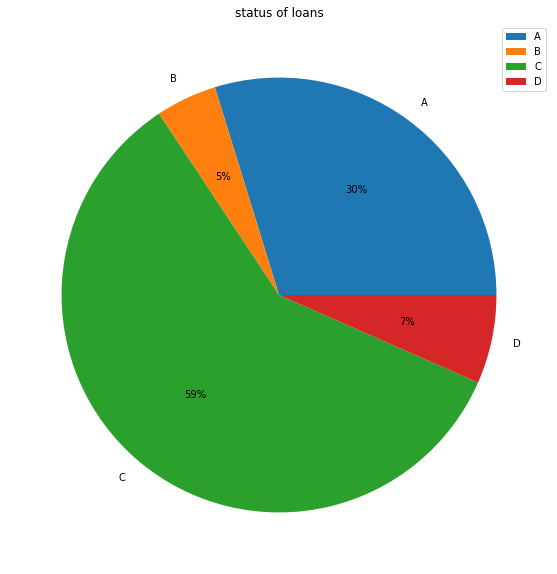

In [1371]:
plt.figure(figsize=(10,10))
plt.pie(count_status, labels=status_list, autopct='%0.0f%%')
plt.legend()
plt.title('status of loans')

<font color="green">Most clients have a running contract that is OK so far.

Among the sample, 7+5=12% of the loans are missing a payment.</font>

### Feature engineering

<font color="green">

In order to predict whether a loan will be paid or not in a relevant manner, I choose to focus on the following features:
    
- **date** when the loan was granted

- **amount** of money

- **duration** of the loan

- **type** of card
    
**Status** of paying off the loan will be used as the value to predict.
    
In this section I focus on operation to prepare the data for machine learning algorithms, that is:
    
- join
    
- conversion 
    
- standardization

</font>

#### Join

In [1372]:
df_disp_for_join = df_disp_cast.select("disp_id", "account_id")

In [1373]:
df_loan_disp = df_loan_cast \
    .join(df_disp_for_join, df_loan_cast.account_id == df_disp_for_join.account_id, 'left') \
    .drop(df_disp_for_join.account_id)

<font color="green">Note: since an account can have several clients (and thus several disp_id), the number of records increase. I think it makes sense to consider different records for different clients.</font>

In [1374]:
df_card_for_join = df_card_cast.select("disp_id","type")

In [1375]:
df_loan_disp_type = df_loan_disp \
    .join(df_card_for_join, df_loan_disp.disp_id == df_card_for_join.disp_id, 'left') \
    .drop(df_card_for_join.disp_id)

#### Conversion

In [1376]:
@udf
def typeToInt(x):
    if(x=="junior"):
        n = 0
    elif(x=="classic"):
        n = 1
    elif(x=="gold"):
        n = 2
    else:
        n = -1
    return n

In [1377]:
@udf
def statusToInt(x):
    if(x=="A"):
        n = 1
    elif(x=="B"):
        n = 2
    elif(x=="C"):
        n = 3
    elif(x=="D"):
        n = 4
    else:
        n = -1
    return n

In [1378]:
from pyspark.sql.functions import unix_timestamp, from_unixtime

# Convert to number
df_type_int = df_loan_disp_type \
    .withColumn("type_2", typeToInt("type")) \
    .withColumn("status_2", statusToInt("status")) \
    .withColumn("date_2", unix_timestamp('date', 'yyy-MM-dd'))

# Change column format
df_type_cast = df_type_int \
    .withColumn("status_int", df_type_int["status_2"].cast("int")) \
    .withColumn("type_int", df_type_int["type_2"].cast("int")) \
    .withColumn("date_int", df_type_int["date_2"].cast("int"))

In [1379]:
df_type_na = df_type_cast \
    .withColumn('type_na', when(df_type_cast.type.isNull(),lit('undefined')).otherwise(df_type_cast.type)) \
    .drop("type","type_2", "status_2", "date_2")

#### Standardization

In [1380]:
df_type_scaled = df_type_na

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType()) # convert column type from vector to double type

for colName in ["amount", "type_int", "date_int", "duration"]:
    assembler = VectorAssembler(inputCols=[colName],outputCol=colName+"_vect") # convert to vector type

    scaler = MinMaxScaler(inputCol=colName+"_vect", outputCol=colName+"_scaled")

    pipeline = Pipeline(stages=[assembler, scaler])
    
    df_type_scaled = pipeline \
        .fit(df_type_scaled) \
        .transform(df_type_scaled) \
        .withColumn(colName+"_scaled", unlist(colName+"_scaled")) \
        .drop(colName+"_vect")

In [1381]:
df_type_scaled_pd = df_type_scaled.toPandas()

In [1382]:
df_type_scaled_pd.head(10)

,loan_id,account_id,date,amount,duration,payments,status,disp_id,status_int,type_int,date_int,type_na,amount_scaled,type_int_scaled,date_int_scaled,duration_scaled
0,4959,2,1994-01-05,80952,24,3373.0,A,3,1,-1,757728000,undefined,0.130,0.000,0.093,0.25
1,4959,2,1994-01-05,80952,24,3373.0,A,2,1,-1,757728000,undefined,0.130,0.000,0.093,0.25
2,4961,19,1996-04-29,30276,12,2523.0,B,25,2,-1,830736000,undefined,0.043,0.000,0.519,0.00
3,4962,25,1997-12-08,30276,12,2523.0,A,31,1,-1,881539200,undefined,0.043,0.000,0.816,0.00
4,4967,37,1998-10-14,318480,60,5308.0,D,45,4,-1,908323200,undefined,0.535,0.000,0.972,1.00
5,4968,38,1998-04-19,110736,48,2307.0,C,46,3,-1,892944000,undefined,0.181,0.000,0.882,0.75
6,4973,67,1996-05-02,165960,24,6915.0,A,78,1,-1,830995200,undefined,0.275,0.000,0.521,0.25
7,4986,97,1997-08-10,102876,12,8573.0,A,117,1,-1,871171200,undefined,0.167,0.000,0.755,0.00
8,4986,97,1997-08-10,102876,12,8573.0,A,116,1,1,871171200,classic,0.167,0.667,0.755,0.00
9,4988,103,1997-12-06,265320,36,7370.0,D,124,4,-1,881366400,undefined,0.444,0.000,0.815,0.50


### Data visualization

#### Groups by type

In [1383]:
def show_samples(samples, labels, dico_labels, features=[0,1], feature_names=None, display_labels=True):
    '''Display the samples in 2D'''
    fig = plt.figure(figsize=(20,10))
    if display_labels:
        nb_labels = np.max(labels)
        for j in range(nb_labels + 1):
            nb_samples = np.sum(labels == j)
            if nb_samples:
                index = np.where(labels == j)[0]
                plt.scatter(samples[index,features[0]],samples[index,features[1]],s=60, label=d[j])
    else:
        plt.scatter(samples[:,features[0]],samples[:,features[1]],color='gray')
    if feature_names is not None:
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    plt.legend(loc=(0.9,0.3))
    plt.axis('auto')
    plt.show()

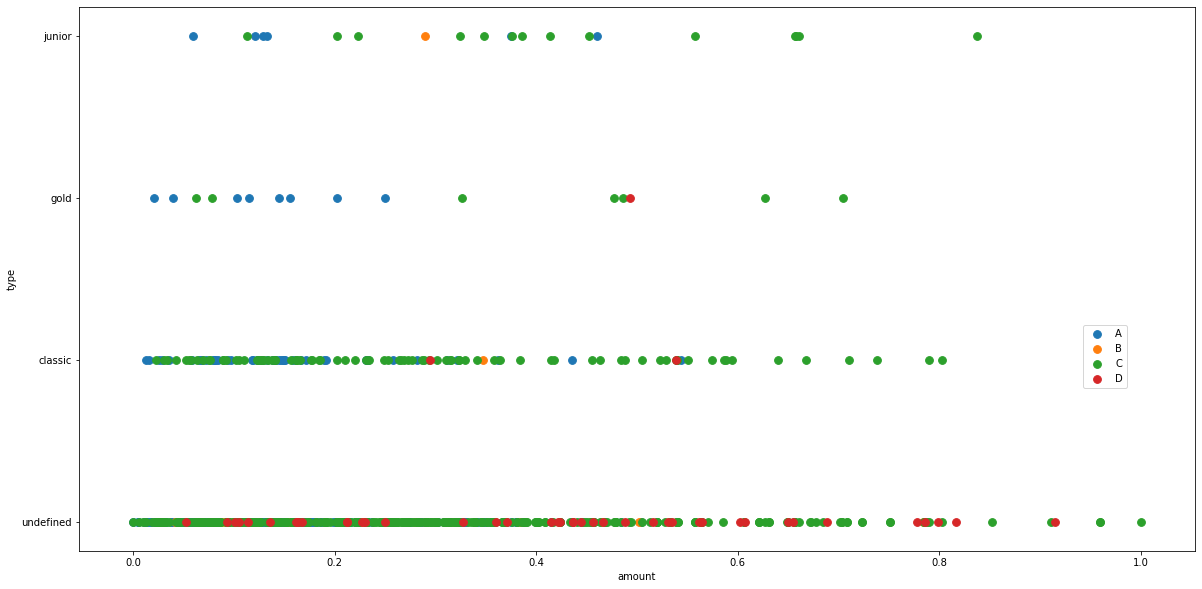

In [1384]:
feature_names = ['amount','type']
d = {1:"A", 2:"B", 3:"C", 4:"D"}
show_samples(samples=np.array(df_type_scaled_pd[["amount_scaled","type_na"]]), \
             labels=np.array(df_type_scaled_pd["status_int"]), dico_labels=d, \
             display_labels=True, feature_names=feature_names)

<font color = "green">

We note:

- Most of the clients who cannot paid their loans do not have a card

- A large proportion of contracts that finished without any issue are for lower amounts

- No junior client are in debt for paying a contract
    
</font>

<font color = "green">It confirms that using the type as a feature is relevant.</font>

#### Dimension reduction for 2D display

In [1385]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]

In [1386]:
pca = PCA(n_components = 2, whiten = True)
X_reduced = pca.fit_transform(X)

In [1387]:
pca.explained_variance_ratio_

array([0.46744466, 0.24673392])

<font color = "green">The dimension reduction allows us to still catch 72% of the variance.</font>

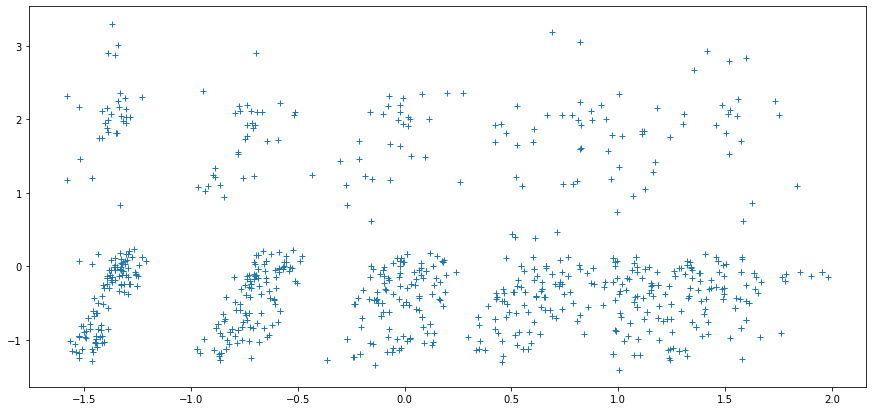

In [1388]:
plt.figure(figsize=(15,7))
plt.plot(X_reduced[:,0],X_reduced[:,1], '+')

<font color = "green">We can see that the data are largely clusterizable.</font>

##  Multiclass approach

#### Linear Regression

<font color = "green">I chose to start with one of the easiest algorithm; it's also the model I know the best so I am able to better extract information of it.</font>

In [1389]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_int"]

In [1390]:
X2 = sm.add_constant(X)

In [1391]:
lr_sm = sm.OLS(Y,X2)
results = lr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             status_int   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     302.2
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          9.20e-160
Time:                        07:43:36   Log-Likelihood:                -787.47
No. Observations:                 827   AIC:                             1585.
Df Residuals:                     822   BIC:                             1609.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5488      0.062     

<font color = "green">

- Relationship is highly significant globally since p-value associated with Fisher stat is very low

- All variables are significant expect the amount

- **Date** and **Duration** are the most important factors

- Type is actually not that important (contrary to what we expected in previous part)
    
</font>

In [1392]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1393]:
clf_lr = LinearRegression()
clf_lr = clf_lr.fit(X_train, Y_train)

In [1394]:
clf_lr.score(X_test, Y_test)

0.605719589380258

<font color = "green">First results seem to be satisfying since we want at least a result > 50%.</font>

<font color = "green">Let's run a cross validation to check whether results are stable with data.</font>

In [1395]:
cross_val_score(clf_lr, X, Y, cv=5)

array([0.51917003, 0.55936348, 0.61817605, 0.62861254, 0.5698181 ])

<font color = "green">Results seem volatile but still satisfying.</font>

#### Decision tree

<font color = "green">The decision tree is a simple algorithm for non linear relations.</font>

In [1396]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_int"]

In [1397]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1398]:
clf_tr = tree.DecisionTreeClassifier(random_state = 0)
clf_tr = clf_tr.fit(X_train,Y_train)

In [1399]:
print(clf_tr.score(X_test, Y_test))

0.8554216867469879


<font color = "green">Result is quite high.</font>

In [1400]:
clf_tr.get_depth()

15

In [1401]:
clf_tr.feature_importances_

array([0.13637863, 0.45521589, 0.39612627, 0.01227921])

<font color = "green">**Date** and **Duration** are the most important features => in line with the Linear Regression</font>

In [1402]:
tree.export_graphviz(clf_tr, out_file="TreeScigility.dot", filled=True)

(Picture displayed using http://viz-js.com/)

<img src = "img/Tree.png"></img>

<font color = "green">The depth is too high to have a good interpretability.</font>

#### AdaBoost (Boosting)

<font color="green">Boosting methods may be well adapted with such few data as we won't be penalised by the computational time.</font>

In [1403]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_int"]

In [1404]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1405]:
clf_adb = AdaBoostClassifier()
clf_adb.fit(X_train, Y_train)
clf_adb.score(X_test, Y_test)

0.6867469879518072

#### KNN

<font color="green">KNN is well adapted for our case since we were able to identify clusters in the data.</font>

In [1406]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_int"]

In [1407]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1408]:
clf_kn = KNeighborsClassifier(n_neighbors=7)
clf_kn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [1409]:
clf_kn.score(X_test, Y_test)

0.8795180722891566

### Binary prediction

In [1410]:
df_type_scaled_pd.head()

,loan_id,account_id,date,amount,duration,payments,status,disp_id,status_int,type_int,date_int,type_na,amount_scaled,type_int_scaled,date_int_scaled,duration_scaled
0,4959,2,1994-01-05,80952,24,3373.0,A,3,1,-1,757728000,undefined,0.130,0.0,0.093,0.25
1,4959,2,1994-01-05,80952,24,3373.0,A,2,1,-1,757728000,undefined,0.130,0.0,0.093,0.25
2,4961,19,1996-04-29,30276,12,2523.0,B,25,2,-1,830736000,undefined,0.043,0.0,0.519,0.00
3,4962,25,1997-12-08,30276,12,2523.0,A,31,1,-1,881539200,undefined,0.043,0.0,0.816,0.00
4,4967,37,1998-10-14,318480,60,5308.0,D,45,4,-1,908323200,undefined,0.535,0.0,0.972,1.00


In [1411]:
df_type_scaled_pd['status_bin'] = np.where(df_type_scaled_pd['status'] == "D", 0, 1)

#### Linear regression

In [1492]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_bin"]

In [1493]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1494]:
clf_lg = LogisticRegression()
clf_lg = clf_lg.fit(X_train,Y_train)

In [1495]:
clf_lg.score(X_test, Y_test)

0.9698795180722891

<font color = "green">Results are even better than in multiclass prediction.</font>

In [1496]:
prob_lg = clf_lg.predict_proba(X_test)
pred_lg = prob_lg[:,1]
fpr_lg, tpr_lg, _ = metrics.roc_curve(Y_test, pred_lg)
roc_auc_lg = metrics.auc(fpr_lg, tpr_lg)

#### Decision tree

In [1487]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_bin"]

In [1488]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1489]:
clf_tr = tree.DecisionTreeClassifier()
clf_tr = clf.fit(X_train,Y_train)
clf_tr.score(X_test, Y_test)

0.6076923076923078

In [1490]:
prob_tr = clf_tr.predict_proba(X_test)
pred_tr = prob_tr[:,1]
fpr_tr, tpr_tr, _ = metrics.roc_curve(Y_test, pred_tr)
roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

#### AdaBoost

In [1473]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_bin"]

In [1474]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1475]:
param_test = {
            'n_estimators':[1,10,20,50,100],
            'learning_rate':[0.1,0.2,0.3,0.5,0.8]
    }

In [1476]:
clf_grid = GridSearchCV(estimator = AdaBoostClassifier(), param_grid = param_test, scoring='roc_auc', cv=5)

In [1477]:
clf_grid.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.8],
                         'n_estimators': [1, 10, 20, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [1478]:
print(clf_grid.best_score_)
print(clf_grid.best_params_)

0.7927847316704459
{'learning_rate': 0.5, 'n_estimators': 10}


In [1479]:
clf_ab = AdaBoostClassifier(n_estimators=100, learning_rate=0.3)
clf_ab = clf_ab.fit(X_train, Y_train)

In [1480]:
prob_ab = clf_ab.predict_proba(X_test)
pred_ab = prob_ab[:,1]
fpr_ab, tpr_ab, _ = metrics.roc_curve(Y_test, pred_ab)
roc_auc_ab = metrics.auc(fpr_ab, tpr_ab)

#### KNN

In [1481]:
X = df_type_scaled_pd[["amount_scaled","date_int_scaled","duration_scaled","type_int_scaled"]]
Y = df_type_scaled_pd["status_bin"]

In [1482]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [1483]:
clf_kn = KNeighborsClassifier(n_neighbors=7)
clf_kn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [1484]:
clf_kn.score(X_test, Y_test)

0.9457831325301205

<font color = "green">Still very high score.</font>

In [1485]:
prob_kn = clf_kn.predict_proba(X_test)
pred_kn = prob_kn[:,1]
fpr_kn, tpr_kn, _ = metrics.roc_curve(Y_test, pred_kn)
roc_auc_kn = metrics.auc(fpr_kn, tpr_kn)

## Model selection

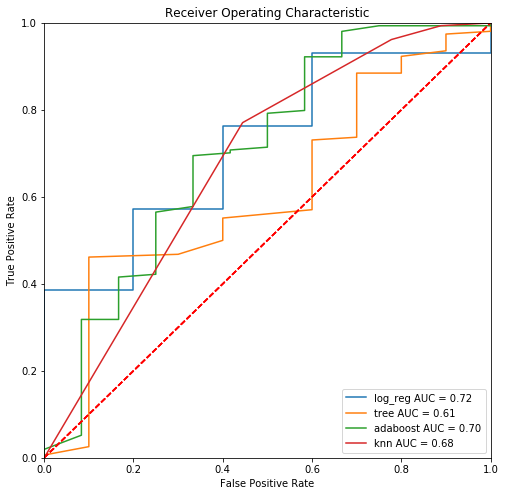

In [1497]:
metric_models = {'log_reg':(fpr_lg, tpr_lg, roc_auc_lg),'tree':(fpr_tr, tpr_tr, roc_auc_tr), \
                 'adaboost':(fpr_ab, tpr_ab, roc_auc_ab), 'knn':(fpr_kn, tpr_kn, roc_auc_kn)}

plt.figure(figsize=(8,8))
for model in metric_models:
    fpr, tpr, roc_auc = metric_models[model]
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = model + ' AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

### Conclusion

<font color="green">

Those predictions can lead to 2 types of errors:

- False positive: the model wrongly predicted that the client will pay its loan

- False negative: the model wrongly predicted that the client won't pay its loan

A bank would probably want to make sure the loans are indeed paid. They will thus be in favor of an algorithm that minize the first error.

Thus, AdaBoost seems the best algorithm.

**Limits**: explainability, computational time with more data.
</font>